## Shipping Label Data Generation
    - Create sythentic Dataset of boxes on a conveyor belt.

#### Import Required Libraries

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

import re

import matplotlib.pylab as plt

import cv2


# from sklearn.model_selection import KFold
# import lightgbm as lgb
# from sklearn.metrics import mean_absolute_error
#plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=6144)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.7.0


#### Yelp Dataset - JSON to Pandas Data Frame

In [ ]:
import time
t_start = time.time()

business_json_path = 'yelp_academic_dataset_business.json'
df_yelp = pd.read_json(business_json_path, lines=True,orient='columns')

t_stop = time.time()
print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

Time elapsed: 2.166 seconds


In [ ]:
df_yelp=df_yelp.drop(['latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'], axis=1)

In [ ]:
df_yelp.head(3)

,business_id,name,address,city,state,postal_code
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711


#### EDA of Cities, States, Zip Codes, etc.

In [ ]:
df_yelp['state'].value_counts()[:10]

PA    34039
FL    26330
TN    12056
IN    11247
MO    10913
LA     9924
AZ     9912
NJ     8536
NV     7715
AB     5573
Name: state, dtype: int64

In [ ]:
df_yelp['city'].value_counts()[:10]

Philadelphia     14569
Tucson            9250
Tampa             9050
Indianapolis      7540
Nashville         6971
New Orleans       6209
Reno              5935
Edmonton          5054
Saint Louis       4827
Santa Barbara     3829
Name: city, dtype: int64

In [ ]:
df_yelp['postal_code'].value_counts()[:10]

93101    1866
89502    1804
70130    1512
19103    1362
19107    1353
19147    1255
37203    1179
85705    1069
33511     940
89431     915
Name: postal_code, dtype: int64

#### Create From and To Shipping Label Lines

In [ ]:
df_yelp.head(3)

,business_id,name,address,city,state,postal_code
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711


In [ ]:
df_yelp['city'][1]+', '+df_yelp['state'][1] + ' '+df_yelp['postal_code'][1]

'Affton, MO 63123'

In [ ]:
df_yelp['Line_1']=df_yelp['name']
df_yelp['Line_2']=df_yelp['address']
df_yelp['Line_3']=df_yelp['city']+', '+df_yelp['state']+ ' '+df_yelp['postal_code']

In [ ]:
df_yelp.head(3)

,business_id,name,address,city,state,postal_code,Line_1,Line_2,Line_3
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2","Santa Barbara, CA 93101"
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,The UPS Store,87 Grasso Plaza Shopping Center,"Affton, MO 63123"
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,Target,5255 E Broadway Blvd,"Tucson, AZ 85711"


#### Visualizing Data - Finished Cardboard Box Sides

https://stackoverflow.com/questions/19471814/display-multiple-images-in-one-ipython-notebook-cell

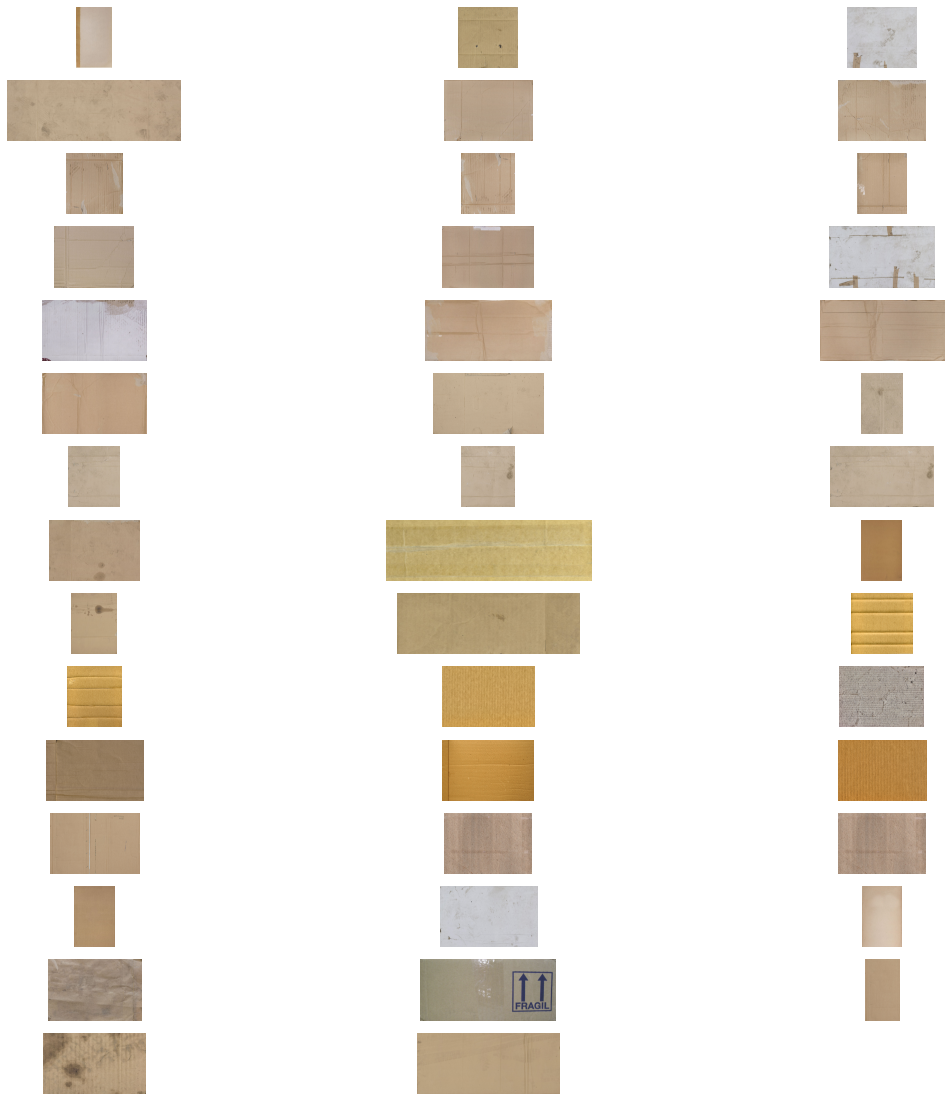

In [ ]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []
for img_path in glob.glob('Finished_Box_Sides/*.jpg'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,20))
columns = 3
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.axis("off")

### First Example - add Shipping Label to 1 Cardboard Box

    - https://machinelearningknowledge.ai/put-text-on-image-in-opencv-python-using-cv2-puttext-with-examples/
    - https://stackoverflow.com/questions/27647424/opencv-puttext-new-line-character
        - using text size to get offset to skip new line

(-0.5, 1547.5, 1062.5, -0.5)

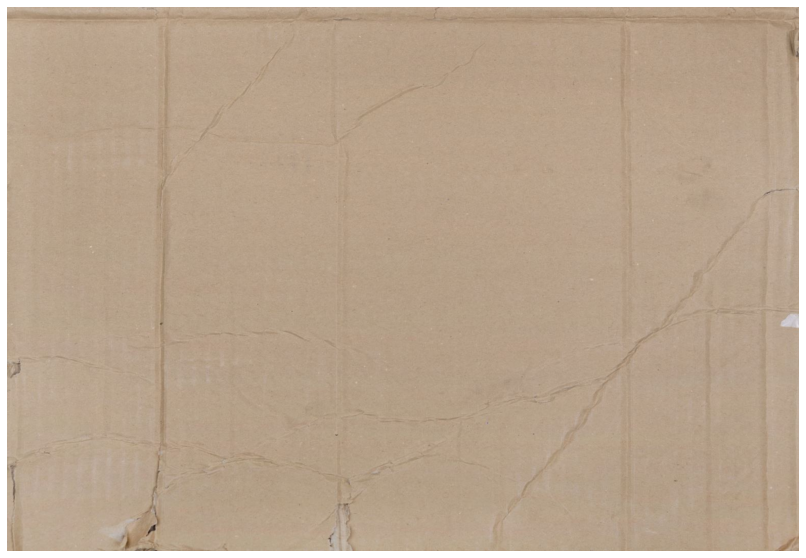

In [ ]:
example_box=images[4].copy()

plt.figure(figsize=(20,10))
plt.imshow(example_box)
plt.axis("off")

### To Address

In [ ]:
ex_line_1=df_yelp['Line_1'][69]
ex_line_2=df_yelp['Line_2'][69]
ex_line_3=df_yelp['Line_3'][69]
ex_line_1

'Publix Super Market'

In [ ]:
example_box.shape

(1063, 1548, 3)

In [ ]:
ln_size=cv2.getTextSize(ex_line_1
                ,fontFace=cv2.FONT_HERSHEY_TRIPLEX
                ,fontScale=2
                ,thickness=2)
ln_size

((724, 43), 19)

In [ ]:
x_offset=int(ln_size[0][0]/2)
y_offset=int(ln_size[0][1]/2)

x_offset_1=int(ln_size[0][0])
y_offset_1=int(ln_size[0][1])

mid_x=int(example_box.shape[0]/2)
mid_y=int(example_box.shape[1]/2)

In [ ]:
ln_size_2=cv2.getTextSize(ex_line_2
                ,fontFace=cv2.FONT_HERSHEY_TRIPLEX
                ,fontScale=2
                ,thickness=2)

x_offset_2=int(ln_size_2[0][0])
y_offset_2=int(ln_size_2[0][1])

(-0.5, 1547.5, 1062.5, -0.5)

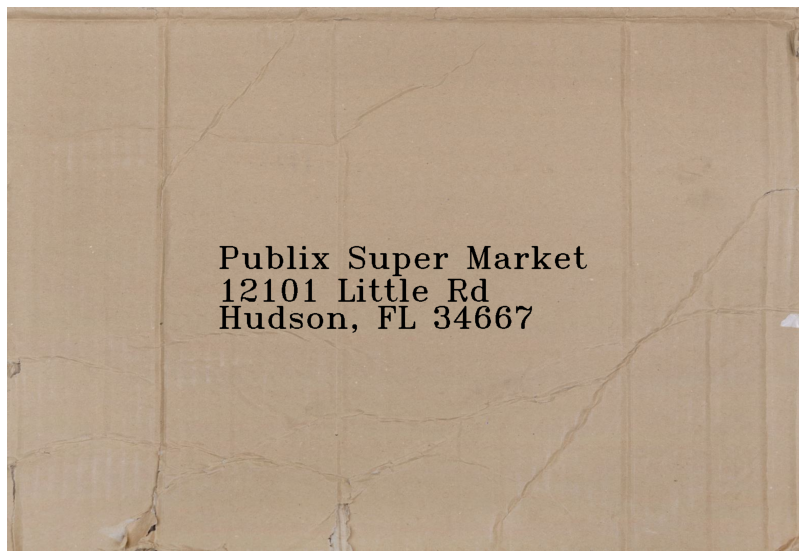

In [ ]:
import cv2

cv2.putText(img=example_box, text=ex_line_1, 
            org=(mid_y-x_offset, mid_x-y_offset), 
            fontFace=cv2.FONT_HERSHEY_TRIPLEX, 
            fontScale=2, color=(0, 0, 0),thickness=2)


cv2.putText(img=example_box, text=ex_line_2, 
            org=(mid_y-x_offset, mid_x+y_offset_1), 
            fontFace=cv2.FONT_HERSHEY_TRIPLEX, 
            fontScale=2, color=(0, 0, 0),thickness=2)

cv2.putText(img=example_box, text=ex_line_3, 
            org=(mid_y-x_offset, mid_x+y_offset_1+y_offset_2+10), 
            fontFace=cv2.FONT_HERSHEY_TRIPLEX, 
            fontScale=2, color=(0, 0, 0),thickness=2)

plt.figure(figsize=(20,10))
plt.imshow(example_box)
plt.axis("off")

### Return Address

In [ ]:
ex_line_1=df_yelp['Line_1'][420]
ex_line_2=df_yelp['Line_2'][420]
ex_line_3=df_yelp['Line_3'][420]
ex_line_1

'Paddy Whacks Irish Sports Pub - South Street'

In [ ]:
ln_size=cv2.getTextSize(ex_line_1
                ,fontFace=cv2.FONT_HERSHEY_TRIPLEX
                ,fontScale=1
                ,thickness=1)
ln_size

((829, 22), 10)

In [ ]:
x_offset=int(ln_size[0][0]/2)
y_offset=int(ln_size[0][1]/2)

x_offset_1=int(ln_size[0][0])
y_offset_1=int(ln_size[0][1])

mid_x=int(example_box.shape[0]/2)
mid_y=int(example_box.shape[1]/2)

(-0.5, 1547.5, 1062.5, -0.5)

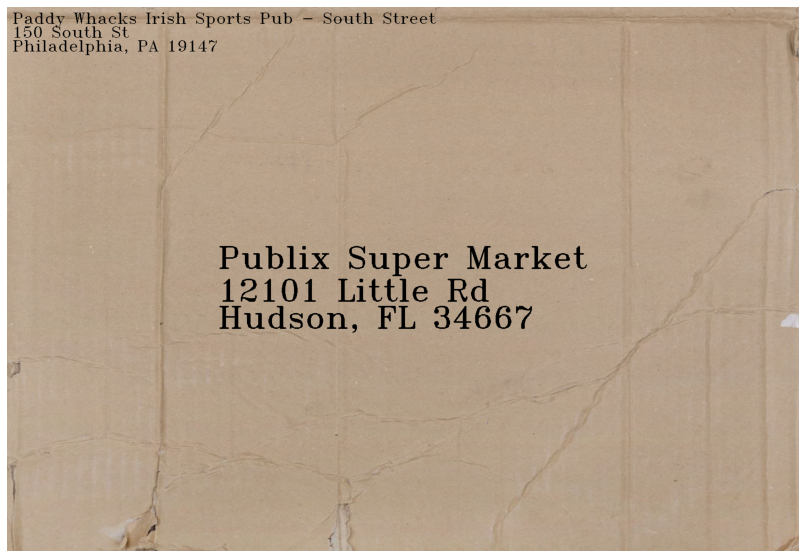

In [ ]:
import cv2

cv2.putText(img=example_box, text=ex_line_1, 
            org=(10, y_offset_1+10), 
            fontFace=cv2.FONT_HERSHEY_TRIPLEX, 
            fontScale=1, color=(0, 0, 0),thickness=1)

cv2.putText(img=example_box, text=ex_line_2, 
            org=(10, y_offset_1+10+y_offset_1+5),  
            fontFace=cv2.FONT_HERSHEY_TRIPLEX, 
            fontScale=1, color=(0, 0, 0),thickness=1)

cv2.putText(img=example_box, text=ex_line_2, 
            org=(10, y_offset_1+10+y_offset_1+5),  
            fontFace=cv2.FONT_HERSHEY_TRIPLEX, 
            fontScale=1, color=(0, 0, 0),thickness=1)

cv2.putText(img=example_box, text=ex_line_3, 
            org=(10, y_offset_1+10+y_offset_1+10+y_offset_1),  
            fontFace=cv2.FONT_HERSHEY_TRIPLEX, 
            fontScale=1, color=(0, 0, 0),thickness=1)



plt.figure(figsize=(20,10))
plt.imshow(example_box)
plt.axis("off")